#This Files' purpose is to evaluate performances of test sets including normal and augmented models.

In [ ]:
# Import Libraries

from google.colab import drive
import pandas as pd
import numpy as np
import torch
from torch.optim import Adam
import torch.nn as nn


drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Define paths to the traned models

# Relular model
model_path = "/content/drive/My Drive/PROJECT/Models/CNNLSTM_NONAUG_NONVAR/DCL-3L_Framewise_81_88.pth"

# Model trained on augmented data
aug_model_path = "/content/drive/My Drive/PROJECT/Models/CNNLSTM_AUG_NONVAR/DCL-3L_Framewise_81_98.pth"

# Introducing and setting up the trained model for classification

In [ ]:
class ConvLSTM(nn.Module):
    """Model for human-activity-recognition."""

    def __init__(self, input_channel, num_classes, cnn_channel):
        super().__init__()
        self.n_layers = 2
        self.num_classes = num_classes
        self.n_hidden = 128

        kernal = (5, 1)

        self.features = nn.Sequential(
            nn.Conv2d(input_channel, cnn_channel, kernel_size=kernal),
            nn.GroupNorm(4, cnn_channel),
            nn.MaxPool2d((2, 1)),
            nn.ReLU(),
            nn.Conv2d(cnn_channel, cnn_channel, kernel_size=kernal),
            nn.GroupNorm(4, cnn_channel),
            nn.MaxPool2d((2, 1)),
            nn.ReLU(),
            nn.Conv2d(cnn_channel, cnn_channel, kernel_size=kernal),
            nn.GroupNorm(4, cnn_channel),
            nn.ReLU(),
            # nn.AdaptiveMaxPool2d((4, input_channel))
        )

        self.lstm1 = nn.LSTM(cnn_channel, hidden_size=self.n_hidden, num_layers=self.n_layers)
        self.fc = nn.Linear(self.n_hidden, self.num_classes)
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = x.unsqueeze(1)
        x = x.permute(0, 3, 2, 1)
        x = self.features(x)

        x = x.permute(2, 0, 3, 1)
        x = x.reshape(x.shape[0], x.shape[1], -1)

        # x, _ = self.lstm1(x)
        # x = self.dropout(x)
        # out = self.fc(x[:, -1])

        x = self.dropout(x)
        x, _ = self.lstm1(x)
        x = x[-1, :, :]
        # x = x.view(x.shape[0], -1, 128)
        out = self.fc(x)

        return out


In [ ]:
# Create and upload Model

model = ConvLSTM(81, num_classes=33, cnn_channel=256)
model_aug = ConvLSTM(81, num_classes=33, cnn_channel=256)
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
checkpoint_aug = torch.load(aug_model_path, map_location=torch.device('cpu'))

optimizer = Adam(model.parameters(), lr=0.001)
optimizer_aug = Adam(model_aug.parameters(), lr=0.001)

model.load_state_dict(checkpoint['model_state_dict'])
model_aug.load_state_dict(checkpoint_aug['model_state_dict'])

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
optimizer_aug.load_state_dict(checkpoint_aug['optimizer_state_dict'])

model.eval()  # Set model to evaluation mode

ConvLSTM(
  (features): Sequential(
    (0): Conv2d(81, 256, kernel_size=(5, 1), stride=(1, 1))
    (1): GroupNorm(4, 256, eps=1e-05, affine=True)
    (2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(5, 1), stride=(1, 1))
    (5): GroupNorm(4, 256, eps=1e-05, affine=True)
    (6): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): Conv2d(256, 256, kernel_size=(5, 1), stride=(1, 1))
    (9): GroupNorm(4, 256, eps=1e-05, affine=True)
    (10): ReLU()
  )
  (lstm1): LSTM(256, 128, num_layers=2)
  (fc): Linear(in_features=128, out_features=33, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

# Load train and test data

In [ ]:
from scipy.io import loadmat

# Upload data set from mat file

matfile_path = "/content/drive/My Drive/PROJECT/REALDISP/REALDISP_NON_AUG.mat"


# Load the .mat file
data = loadmat(matfile_path)

# View the keys in the .mat file
print(data.keys())

# Extract testData and testLabels
X_test = data['testData']
y_test = data['testLabels'].reshape(-1)

# Extract trainData
X_train = data['trainData']
y_train = data['trainLabels'].reshape(-1)

# Check their shapes
print("testData shape:", X_test.shape)
print("testLabels shape:", y_test.shape)
print(X_train.shape)

dict_keys(['__header__', '__version__', '__globals__', 'trainData', 'valData', 'testData', 'trainLabels', 'valLabels', 'testLabels'])
testData shape: (123136, 81)
testLabels shape: (123136,)
(1304832, 81)


# Chaining 9 copies of test data for an experiment to make 6 hour length set

In [ ]:
X_test = np.tile(X_test, (9, 1))
y_test = np.tile(y_test, 9)

print(X_test.shape)
print(y_test.shape)

(1108224, 81)
(1108224,)
[12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
 12. 12. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 1

# Misaligning Data

In [ ]:
s# -------------------------------
# Purpose:
# This script simulates misalignment in a multi-sensor HAR dataset by applying two types
# of synthetic timing distortions:
# (1) Dropping rows to mimic slower sensor sampling, and
# (2) Interpolating rows to simulate faster sampling (clock drift).
# The updated sensor streams are then checked for shape consistency.
# -------------------------------

# Split full test dataset into individual 9-axis sensor streams
sensor1 = X_test[:, :9]
sensor2 = X_test[:, 9:18]
sensor3 = X_test[:, 18:27]
sensor4 = X_test[:, 27:36]
sensor5 = X_test[:, 36:45]
sensor6 = X_test[:, 45:54]
sensor7 = X_test[:, 54:63]
sensor8 = X_test[:, 63:72]
sensor9 = X_test[:, 72:81]

sensor_set = [sensor1, sensor2, sensor3, sensor4, sensor5, sensor6, sensor7, sensor8, sensor9]

# Replicate labels for each sensor stream
label_set = np.tile(y_test[:, np.newaxis], 9).T  # Shape: (num_sensors, frames)

# Define sensor indices for each misalignment scenario
sensor_index_for_3_drop = [1, 5]
sensor_index_for_3_inter = [6]
sensor_index_for_6_drop = [1, 5, 6, 3]
sensor_index_for_6_inter = [8, 7]
sensor_index_for_9_drop = [1, 3, 4, 6]
sensor_index_for_9_inter = [2, 5, 7, 8, 9]

# Set the misalignment frequency (row interval)
misaligning_row = 32000  # Corresponds to ~0.7s drift over 6 hours (50.0015625 Hz)

# -------------------------
# DROP FUNCTION
def drop_rows(sensor_set, sensor_indices, labels, misaligning_row):
    """
    Simulates slower sensor sampling by dropping every N-th row in selected sensors.

    Args:
        sensor_set (list): List of sensor arrays (frames x axes).
        sensor_indices (list): 1-based indices of sensors to drop rows from.
        labels (list): List of label arrays per sensor.
        misaligning_row (int): Drop every N-th row.

    Returns:
        updated_sensors (list), updated_labels (list)
    """
    updated_sensors = []
    updated_labels = []

    for i, sensor in enumerate(sensor_set):
        if i + 1 in sensor_indices:  # Match 1-based indexing
            mask = np.ones(sensor.shape[0], dtype=bool)
            mask[::misaligning_row] = False  # Drop every N-th row
            updated_sensors.append(sensor[mask])
            updated_labels.append(labels[i][mask])
        else:
            updated_sensors.append(sensor)
            updated_labels.append(labels[i])
    return updated_sensors, updated_labels

# -------------------------
# INTERPOLATION FUNCTION
def interpolate(sensor_set, sensor_indices, labels, misaligning_row):
    """
    Simulates faster sensor sampling by inserting interpolated rows every N-th frame.

    Args:
        sensor_set (list): List of sensor arrays.
        sensor_indices (list): 1-based indices of sensors to apply interpolation.
        labels (list): Label arrays per sensor.
        misaligning_row (int): Insert a row every N-th frame.

    Returns:
        updated_sensors (list), updated_labels (list)
    """
    updated_sensors = []
    updated_labels = []

    for inx, sensor in enumerate(sensor_set):
        sensor_labels = labels[inx]
        if inx + 1 in sensor_indices:
            rows, cols = sensor.shape
            interpolated_data = []
            interpolated_labels = []

            for i in range(rows):
                interpolated_data.append(sensor[i])
                interpolated_labels.append(sensor_labels[i])

                # Insert interpolated row every N-th frame
                if i % misaligning_row == 0 and i + 1 < rows:
                    interpolated_row = (sensor[i] + sensor[i + 1]) / 2
                    interpolated_data.append(interpolated_row)
                    interpolated_labels.append(sensor_labels[i])  # Use previous label

            updated_sensors.append(np.array(interpolated_data))
            updated_labels.append(np.array(interpolated_labels))
        else:
            updated_sensors.append(sensor)
            updated_labels.append(sensor_labels)

    return updated_sensors, updated_labels

# -------------------------
# Apply 9-sensor misalignment scenario (drop + interpolate)
sensor_set, label_set = drop_rows(sensor_set, sensor_index_for_9_drop, label_set, misaligning_row)
sensor_set, label_set = interpolate(sensor_set, sensor_index_for_9_inter, label_set, misaligning_row)

# Output shapes for validation
for idx, sensor in enumerate(sensor_set, start=1):
    print(f"Sensor {idx} shape: {sensor.shape}, Label shape: {len(label_set[idx-1])}")

Sensor 1 shape: (1108189, 9), Label shape: 1108189
Sensor 2 shape: (1108259, 9), Label shape: 1108259
Sensor 3 shape: (1108189, 9), Label shape: 1108189
Sensor 4 shape: (1108189, 9), Label shape: 1108189
Sensor 5 shape: (1108259, 9), Label shape: 1108259
Sensor 6 shape: (1108189, 9), Label shape: 1108189
Sensor 7 shape: (1108259, 9), Label shape: 1108259
Sensor 8 shape: (1108259, 9), Label shape: 1108259
Sensor 9 shape: (1108259, 9), Label shape: 1108259


In [ ]:
# -----------------------------
# Purpose:
# After misalignment, sensors may have different lengths due to dropped or interpolated rows.
# This code aligns all sensors to the same minimum length, recomputes unified labels,
# and concatenates all sensor streams back into a single test matrix (X_test).
# -----------------------------

# Step 1: Find the minimum number of rows across all sensors
min_row = min([sensor.shape[0] for sensor in sensor_set])

# Step 2: Trim all sensor and label arrays to the same minimum length
for i in range(len(sensor_set)):
    sensor_set[i] = sensor_set[i][:min_row]      # Trim sensor data
    label_set[i] = label_set[i][:min_row]        # Trim corresponding labels

# Step 3: Stack all label arrays into a single 2D array: shape [num_sensors, frames]
stacked_labels = np.stack(label_set, axis=0)
print("Stacked labels shape:", stacked_labels.shape)

# Step 4: Recompute y_test by taking the most frequent (mode) label per time step
# This ensures one final label per frame across all sensors
y_test = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=stacked_labels.astype(int))

# Step 5: Output shapes of trimmed sensors for verification
for idx, sensor in enumerate(sensor_set, start=1):
    print(f"Sensor {idx} shape: {sensor.shape}")

# Step 6: Concatenate all sensor data horizontally to reconstruct the full X_test matrix
X_test = np.concatenate(sensor_set, axis=1)

# Final shape outputs
print("Updated X_test shape:", X_test.shape)  # Expected shape: [frames, 81]
print(f"y_test shape: {y_test.shape}")        # Expected shape: [frames]

(9, 1108189)
Sensor 1 shape: (1108189, 9)
Sensor 2 shape: (1108189, 9)
Sensor 3 shape: (1108189, 9)
Sensor 4 shape: (1108189, 9)
Sensor 5 shape: (1108189, 9)
Sensor 6 shape: (1108189, 9)
Sensor 7 shape: (1108189, 9)
Sensor 8 shape: (1108189, 9)
Sensor 9 shape: (1108189, 9)
Updated X_test shape: (1108189, 81)
y_test shape: (1108189,)


# Normalising Data

In [ ]:
mean_train = np.mean(X_train, axis=0)
std_train = np.std(X_train, axis=0)
X_test = (X_test - mean_train) / std_train

# Segmenting data (Windowing)

In [ ]:
from numpy.lib.stride_tricks import as_strided as ast
from scipy.stats import mode
from collections import Counter

# Purpose:
# This module applies sliding window segmentation to time-series data (e.g., sensor data).
# It includes two modes:
# 1. Standard windowing with label assignment (e.g., last or most frequent label per window).
# 2. Filtering to keep only windows where all labels are the same (for clean labeling).
# -----------------------------

def norm_shape(shape):
    """
    Ensures shape input is returned as a tuple.
    Accepts either a single int or an iterable (e.g., list, tuple).
    """
    try:
        return (int(shape),)
    except TypeError:
        pass

    try:
        return tuple(shape)
    except TypeError:
        pass

    raise TypeError('shape must be an int, or a tuple of ints')

def sliding_window(a, ws, ss=None, flatten=True):
    """
    Creates a sliding window view over a NumPy array.

    Args:
        a (np.ndarray): Input array (e.g., time-series data).
        ws (int or tuple): Window size.
        ss (int or tuple): Step size. Defaults to no overlap (equal to ws).
        flatten (bool): If True, output is reshaped into 2D.

    Returns:
        np.ndarray: Windowed slices of the input array.
    """
    if ss is None:
        ss = ws

    ws = norm_shape(ws)
    ss = norm_shape(ss)
    shape = np.array(a.shape)

    # Ensure dimensional consistency
    if len(set([len(shape), len(ws), len(ss)])) != 1:
        raise ValueError(f'a.shape, ws and ss must all have the same length. They were {[len(shape), len(ws), len(ss)]}')

    if np.any(ws > shape):
        raise ValueError(f'ws cannot be larger than a in any dimension. a.shape was {a.shape} and ws was {ws}')

    # Calculate output shape and strides
    newshape = norm_shape(((shape - ws) // ss) + 1) + norm_shape(ws)
    newstrides = norm_shape(np.array(a.strides) * ss) + a.strides

    strided = ast(a, shape=newshape, strides=newstrides)

    if not flatten:
        return strided

    # Flatten windows for model input: [num_windows, window_size, num_features]
    meat = len(ws) if ws.shape else 0
    firstdim = (np.prod(newshape[:-meat]),) if ws.shape else ()
    dim = firstdim + (newshape[-meat:])
    return strided.reshape(dim)

def data_sliding_window(data_x, data_y, ws, ss):
    """
    Applies sliding window to feature and label arrays.

    Args:
        data_x (np.ndarray): Feature data [frames, features].
        data_y (np.ndarray): Label data [frames].
        ws (int): Window size.
        ss (int): Step/stride size.

    Returns:
        tuple: windowed data_x and data_y with labels taken from the last frame in each window.
    """
    data_x = sliding_window(data_x, (ws, data_x.shape[1]), (ss, 1))
    data_y = np.asarray([[i[-1]] for i in sliding_window(data_y, ws, ss)])
    # Alternative: use mode label in window instead of last label
    # data_y = np.asarray([[mode(i)[0]] for i in sliding_window(data_y, ws, ss)])
    return data_x.astype(np.float32), data_y.reshape(len(data_y)).astype(np.uint8)

def data_sliding_window_single_label(data_x, data_y, ws, ss):
    """
    Applies sliding window and keeps only windows where all labels are the same.

    Args:
        data_x (np.ndarray): Feature data.
        data_y (np.ndarray): Label data.
        ws (int): Window size.
        ss (int): Step size.

    Returns:
        tuple: Filtered windows and their corresponding labels.
    """
    updated_data_x = []
    single_label_windows = []

    # Apply windowing to both features and labels
    data_x = sliding_window(data_x, (ws, data_x.shape[1]), (ss, 1))
    label_windows = sliding_window(data_y, ws, ss)

    for labels, feats in zip(label_windows, data_x):
        label_counts = Counter(labels)
        if len(label_counts) == 1:  # All labels in window are identical
            single_label_windows.append(labels)
            updated_data_x.append(feats)

    data_x = np.asarray(updated_data_x)
    #data_y = np.asarray([[i[-1]] for i in single_label_windows])  # Use last label
    #  use mode label
    data_y = np.asarray([[mode(i)[0]] for i in single_label_windows])
    return data_x.astype(np.float32), data_y.reshape(len(data_y)).astype(np.uint8)

# -----------------------------
# Example execution
window_size = 64
step_size = 32

# Apply regular sliding window
X_test_windows, y_test_windows = data_sliding_window(X_test, y_test, window_size, step_size)

# Optionally filter to keep only windows with consistent labels
X_test_windows, y_test_windows = data_sliding_window_single_label(X_test, y_test, window_size, step_size)

<ipython-input-28-951ad1990405>:72: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  data_x = sliding_window(data_x, (ws, data_x.shape[1]), (ss, 1))
<ipython-input-28-951ad1990405>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i = int(shape)
<ipython-input-28-951ad1990405>:73: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  data_y = np.asarray([[i[-1]] for i in sliding_window(data_y, ws, ss)])  # Choose last one


34629


In [ ]:
print("X_test_windows shape:", X_test_windows.shape)
print("y_test_windows shape:", y_test_windows.shape)

X_test_windows shape: (34629, 64, 81)
y_test_windows shape: (34629,)


Make artificial transitions to the different activities within each window.
not introducing any external data, ensuring that both the original and transitioned datasets originate from the same source. This ensures that any performance difference between models trained on original vs. transitioned data is purely due to the transitions and not additional external influences.

In [ ]:
def simulate_transitions_front(X_test_windows):
    """
    Simulates transitions within each window by replacing a randomly chosen
    fraction (10%-50%) of the first part of the window with shuffled fragments
    from other windows.

    Args:
        X_test_windows (numpy.ndarray): Array of shape (num_windows, window_size, num_features)

    Returns:
        numpy.ndarray: Modified array with simulated transitions.
    """
    num_windows, window_size, num_features = X_test_windows.shape
    extracted_parts = []  # Store extracted first parts

    # Step 1: Extract variable-length first parts from each window
    for window in X_test_windows:
        # Randomly select a fraction (between 10% and 50%) of the first part
        fraction = np.random.uniform(0.15, 0.5)
        cut_point = int(fraction * window_size)  # Determine how many frames to extract

        # Store the extracted part
        extracted_parts.append(window[:cut_point, :])

    # Step 2: Shuffle the extracted parts to introduce transitions
    np.random.shuffle(extracted_parts)

    # Step 3: Replace the first part of each window with a randomly chosen shuffled segment
    modified_windows = []
    for i, window in enumerate(X_test_windows):
        new_first_part = extracted_parts[i]  # Take the shuffled extracted part
        cut_point = new_first_part.shape[0]  # Ensure it fits exactly

        # Create a modified window with the new first part replacing the original
        modified_window = np.copy(window)  # Copy to avoid modifying original data
        modified_window[:cut_point, :] = new_first_part  # Replace first part

        modified_windows.append(modified_window)

    # Convert list back to numpy array
    return np.array(modified_windows)

def simulate_transitions_back(X_test_windows):
    """
    Simulates transitions within each window by replacing a randomly chosen
    fraction (10%-15%) of the last part of the window with shuffled fragments
    from other windows.

    Args:
        X_test_windows (numpy.ndarray): Array of shape (num_windows, window_size, num_features)

    Returns:
        numpy.ndarray: Modified array with simulated transitions.
    """
    num_windows, window_size, num_features = X_test_windows.shape
    extracted_parts = []  # Store extracted last parts

    # Step 1: Extract variable-length last parts from each window
    for window in X_test_windows:
        # Randomly select a fraction (between 10% and 15%) of the last part
        fraction = np.random.uniform(0.15, 0.50)
        cut_point = int(fraction * window_size)  # Determine how many frames to extract

        # Store the extracted last part
        extracted_parts.append(window[-cut_point:, :])  # Take from the end

    # Step 2: Shuffle the extracted parts to introduce transitions
    np.random.shuffle(extracted_parts)

    # Step 3: Replace the last part of each window with a randomly chosen shuffled segment
    modified_windows = []
    for i, window in enumerate(X_test_windows):
        new_last_part = extracted_parts[i]  # Take the shuffled extracted part
        cut_point = new_last_part.shape[0]  # Ensure it fits exactly

        # Create a modified window with the new last part replacing the original
        modified_window = np.copy(window)  # Copy to avoid modifying original data
        modified_window[-cut_point:, :] = new_last_part  # Replace last part

        modified_windows.append(modified_window)

    # Convert list back to numpy array
    return np.array(modified_windows)


# Apply the function
#X_test_windows = simulate_transitions_front(X_test_windows)
#X_test_windows = simulate_transitions_back(X_test_windows)


#Converts preprocessed test data (windowed X_test and y_test) into PyTorch tensors, wraps them into a DataLoader, performs batch-wise prediction using a trained model, and collects the predicted and true labels for evaluation.

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

X_test_torch = torch.tensor(X_test_windows, dtype=torch.float32)
y_test_torch = torch.tensor(y_test_windows, dtype=torch.long)

# Create a DataLoader
test_dataset = TensorDataset(X_test_torch, y_test_torch)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:  # Retrieve both features and labels
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.numpy())
        true_labels.extend(labels.numpy())

In [ ]:
 #Make Prediction using model with augmented training data

 predictions_aug = []

 with torch.no_grad():
     for inputs, labels in test_loader:  # Retrieve both features and labels
         outputs = model_aug(inputs)
         _, preds = torch.max(outputs, 1)
         predictions_aug.extend(preds.numpy())

#Testing

Check performance also of the second half and last quarter of predictions

In [ ]:
predictions = np.array(predictions) + 1
predictions_aug = np.array(predictions_aug) + 1

predictions_half = predictions[int(len(predictions)/2):]
true_labels_half = true_labels[int(len(true_labels)/2):]

predictions_quat = predictions[int(len(predictions)*0.75):]
true_labels_quat = true_labels[int(len(true_labels)*0.75):]

aug_predictions_half = predictions_aug[int(len(predictions_aug)/2):]
aug_predictions_quat = predictions_aug[int(len(predictions_aug)*0.75):]

Accuracy NoAug/Aug: 0.7668
Macro F1-Score: 0.7620
Weighted F1-Score: 0.7615


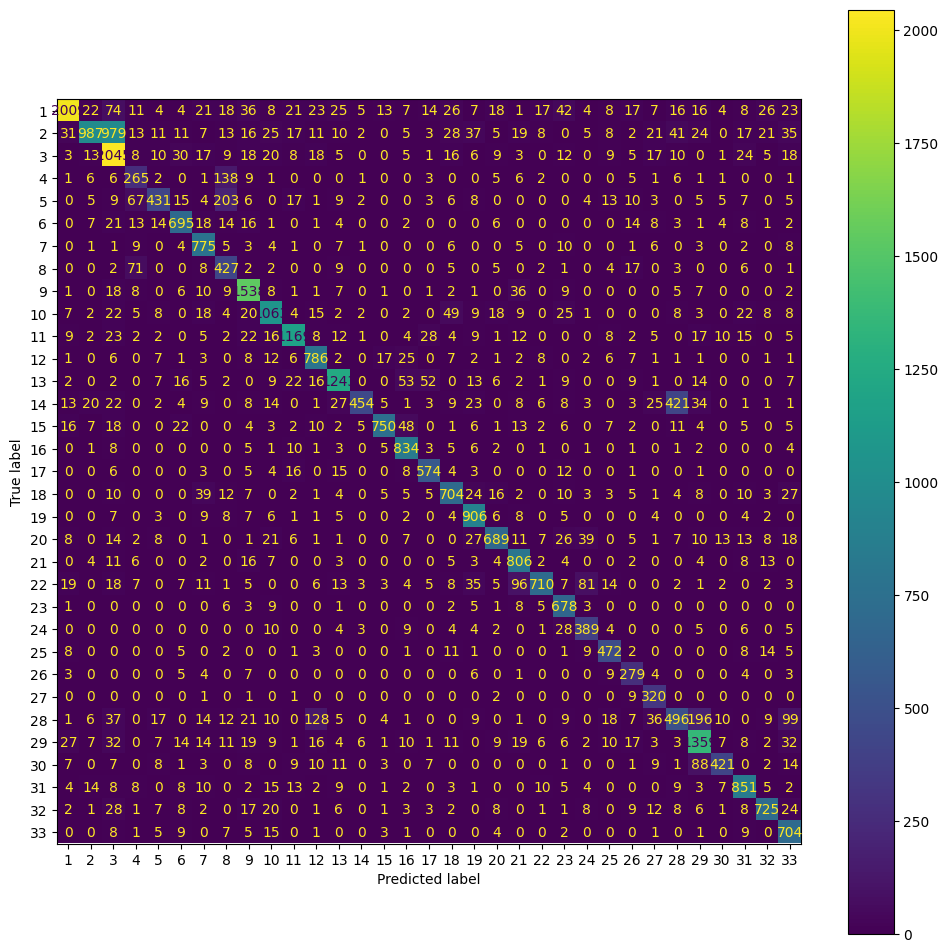

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# Set up figure and axes manually
fig, ax = plt.subplots(figsize=(12, 12))  # Adjust the size as needed

# Generate the confusion matrix and display it on the provided axes
ConfusionMatrixDisplay.from_predictions(true_labels, predictions, ax=ax)

# Compute metrics
accuracy = accuracy_score(true_labels, predictions)
f1_macro = f1_score(true_labels, predictions, average='macro')
f1_weighted = f1_score(true_labels, predictions, average='weighted')

# Compute metrics from predictions from the model trained on augmented model
accuracy_aug = accuracy_score(true_labels, predictions_aug)
f1_macro_aug = f1_score(true_labels, predictions_aug, average='macro')
f1_weighted_aug = f1_score(true_labels, predictions_aug, average='weighted')

print(f"Accuracy NoAug/Aug: {accuracy:.4f} / {accuracy_aug:.4f}")
print(f"Macro F1-Score: {f1_macro:.4f} / {f1_macro_aug:.4f}")
print(f"Weighted F1-Score: {f1_weighted:.4f} / {f1_weighted_aug:.4f}")


print(f"Accuracy NoAug/Aug: {accuracy:.4f}")
print(f"Macro F1-Score: {f1_macro:.4f}")
print(f"Weighted F1-Score: {f1_weighted:.4f}")

plt.show()

In [ ]:
#fig, ax = plt.subplots(figsize=(12, 12))  # Adjust the size as needed

# Generate the confusion matrix and display it on the provided axes
#ConfusionMatrixDisplay.from_predictions(true_labels_half, predictions_half, ax=ax)

# Compute metrics
accuracy = accuracy_score(true_labels_half, predictions_half)
f1_macro = f1_score(true_labels_half, predictions_half, average='macro')
f1_weighted = f1_score(true_labels_half, predictions_half, average='weighted')

accuracy_aug = accuracy_score(true_labels_half, aug_predictions_half)
f1_macro_aug = f1_score(true_labels_half, aug_predictions_half, average='macro')
f1_weighted_aug = f1_score(true_labels_half, aug_predictions_half, average='weighted')

print(f"Accuracy NoAug/Aug: {accuracy:.4f} / {accuracy_aug:.4f}")
print(f"Macro F1-Score: {f1_macro:.4f} / {f1_macro_aug:.4f}")
print(f"Weighted F1-Score: {f1_weighted:.4f} / {f1_weighted_aug:.4f}")

print(f"Accuracy NoAug/Aug: {accuracy:.4f}")
print(f"Macro F1-Score: {f1_macro:.4f}")
print(f"Weighted F1-Score: {f1_weighted:.4f}")

#plt.show()

Accuracy NoAug/Aug: 0.7447
Macro F1-Score: 0.7404
Weighted F1-Score: 0.7389


In [ ]:
#fig, ax = plt.subplots(figsize=(12, 12))  # Adjust the size as needed

# Generate the confusion matrix and display it on the provided axes
#ConfusionMatrixDisplay.from_predictions(true_labels_quat, predictions_quat, ax=ax)

# Compute metrics
accuracy = accuracy_score(true_labels_quat, predictions_quat)
f1_macro = f1_score(true_labels_quat, predictions_quat, average='macro')
f1_weighted = f1_score(true_labels_quat, predictions_quat, average='weighted')

accuracy_aug = accuracy_score(true_labels_quat, aug_predictions_quat)
f1_macro_aug = f1_score(true_labels_quat, aug_predictions_quat, average='macro')
f1_weighted_aug = f1_score(true_labels_quat, aug_predictions_quat, average='weighted')

print(f"Accuracy NoAug/Aug: {accuracy:.4f} / {accuracy_aug:.4f}")
print(f"Macro F1-Score: {f1_macro:.4f} / {f1_macro_aug:.4f}")
print(f"Weighted F1-Score: {f1_weighted:.4f} / {f1_weighted_aug:.4f}")

print(f"Accuracy NoAug/Aug: {accuracy:.4f}")
print(f"Macro F1-Score: {f1_macro:.4f}")
print(f"Weighted F1-Score: {f1_weighted:.4f}")

#plt.show()

Accuracy NoAug/Aug: 0.7477
Macro F1-Score: 0.7415
Weighted F1-Score: 0.7418


Compute Further Metrics

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def per_class_accuracy(true_labels, predictions):
    """
    Computes accuracy for each individual class.
    """
    unique_classes = np.unique(true_labels)  # Get all unique class labels
    class_accuracies = {}

    for cls in unique_classes:
        # Filter predictions and true labels for the current class
        mask = true_labels == cls
        class_acc = accuracy_score(true_labels[mask], predictions[mask])
        class_accuracies[cls] = class_acc  # Store per-class accuracy

    return class_accuracies

def evaluate_top_bottom_accuracies(true_labels, predictions, name="Predictions"):
    """
    Evaluates:
    - Accuracy for overall data
    - Accuracy for top 5 classes (most correctly predicted)
    - Accuracy for bottom 5 classes (least correctly predicted)
    - Mean F1-score
    - F1-score Standard Deviation
    """

    print(f"\n=== Evaluating {name} ===")

    # Compute overall accuracy
    overall_accuracy = accuracy_score(true_labels, predictions)
    print(f"Overall Accuracy: {overall_accuracy:.4f}")

    # Compute per-class accuracy
    class_accuracies = per_class_accuracy(true_labels, predictions)

    # Sort classes by accuracy
    sorted_classes = sorted(class_accuracies.items(), key=lambda x: x[1], reverse=True)

    # Extract top 5 and bottom 5 classes
    top_5_classes = [cls for cls, _ in sorted_classes[:5]]
    bottom_5_classes = [cls for cls, _ in sorted_classes[-5:]]

    print(f"Top 5 Classes: {top_5_classes}")
    print(f"Bottom 5 Classes: {bottom_5_classes}")

    # Filter predictions for top 5 and bottom 5 classes
    top5_mask = np.isin(true_labels, top_5_classes)
    bottom5_mask = np.isin(true_labels, bottom_5_classes)

    # Compute accuracy for top 5 and bottom 5 activities
    accuracy_top5 = accuracy_score(true_labels[top5_mask], predictions[top5_mask])
    accuracy_bottom5 = accuracy_score(true_labels[bottom5_mask], predictions[bottom5_mask])

    print(f"Top 5 Accuracy: {accuracy_top5:.4f}")
    print(f"Bottom 5 Accuracy: {accuracy_bottom5:.4f}")

    # Compute Mean F1-score and F1-score Standard Deviation
    f1_scores = f1_score(true_labels, predictions, average=None)  # Get F1-score for each class
    mean_f1 = np.mean(f1_scores)  # Compute mean F1-score
    std_f1 = np.std(f1_scores)  # Compute standard deviation of F1-scores

    print(f"Mean F1-score: {mean_f1:.4f}")
    print(f"F1-score Standard Deviation: {std_f1:.4f}")

    return {
        "overall_accuracy": overall_accuracy,
        "top_5_classes": top_5_classes,
        "bottom_5_classes": bottom_5_classes,
        "top_5_accuracy": accuracy_top5,
        "bottom_5_accuracy": accuracy_bottom5,
        "mean_f1": mean_f1,
        "std_f1": std_f1
    }

# Example usage
results_half = evaluate_top_bottom_accuracies(
    np.array(true_labels), np.array(predictions),
    name="Non-Augmented Predictions (Second Half)"
)
#results_aug_half = evaluate_top_bottom_accuracies(
#    np.array(true_labels_half), np.array(aug_predictions_half),
#    name="Augmented Predictions (Second Half)"
#)



=== Evaluating Non-Augmented Predictions (Second Half) ===
Overall Accuracy: 0.7668
Top 5 Classes: [27, 23, 16, 9, 19]
Bottom 5 Classes: [4, 5, 28, 2, 14]
Top 5 Accuracy: 0.9278
Bottom 5 Accuracy: 0.4401
Mean F1-score: 0.7620
F1-score Standard Deviation: 0.1071
